## Simulation of the Heston model using the Quadratic exponential scheme

In order to achieve maximum performance of Pytorch in a Monte-Carlo simulation it is critical to vectorize over the number of simulations. Thus we need to remove all 'if' statements from the Quadratic Exponential scheme.

In [1]:
import torch
import numpy as np
from quant_analytics_torch.analytics import blackanalytics

In [3]:
paths =2**15-1
n_dt = 32
paths

32767

In [4]:
rho = torch.tensor(-0.5, requires_grad=True)
theta = torch.tensor((0.2)**2, requires_grad=True)
kappa = torch.tensor(1., requires_grad=True)
eta= torch.tensor(0.5, requires_grad=True)
T = 1
dt = T/n_dt
dim = n_dt

In [5]:
gamma1 = 0.5
gamma2 = 0.5

K0 = -1*(rho*kappa*theta)*dt/eta
K1 = gamma1*dt*(-0.5+(kappa*rho/eta))-(rho/eta)
K2 = gamma2*dt*(-0.5+(kappa*rho/eta))+(rho/eta)
K3 = gamma1*dt*(1-rho**2)
K4 = gamma2*dt*(1-rho**2)


In [6]:
X = torch.zeros([paths])
V = torch.zeros([n_dt+1,paths])
Vt = torch.zeros([paths])
Vt[:] = theta
V[0] = theta

In [7]:
sobol_engine =  torch.quasirandom.SobolEngine(2*dim)
x = sobol_engine.draw(1)

In [8]:
u = sobol_engine.draw(paths,dtype=torch.float64)

In [9]:
u = torch.transpose(u,0,1)
# Random variable for the underlying
u1 = u[:dim]
# Random variables for the volatility
u2 = u[dim:]

In [10]:
from quant_analytics_torch.analytics.norminv import norminv
from quant_analytics_torch.analytics import maxsoft
from quant_analytics_torch.analytics.characteristicfunction import heston_option_price

In [11]:
import matplotlib
from matplotlib import pyplot as plt

In [12]:
for i in range(n_dt):
    minusexpkappadt = torch.exp(-kappa*dt)
    m = theta+( Vt - theta) * minusexpkappadt
    s2 = ((Vt*eta**2) * minusexpkappadt/kappa)*(1-minusexpkappadt) + ( theta*eta**2)*((1-minusexpkappadt)**2)/(2*kappa)
    phi = s2/m**2
    #
    # Calculate the lower branch
    #
    b2 = torch.maximum((2/phi)-1+2*(torch.sqrt(2/phi))*(torch.sqrt(torch.maximum(-1+2/phi, torch.tensor(0.)))),torch.tensor(0.))
    a = m/(1+b2)
    z2 = norminv(u2[i])
    Vnew_1 = a*(z2 + b2**0.5)**2
    #
    # Calulcate the upper branch
    #
    p = (phi-1)/(phi+1)
    beta = 2/(m+m*phi)
    Vnew_2 = torch.log((1-p)/(1-u2[i])) / beta
    Vnew_2 = torch.maximum(Vnew_2, torch.tensor(0.))
    phiC = 1.5
    #
    # Switch the branches
    #
    p_1 = maxsoft.soft_heavy_side_hyperbolic(phiC-phi)
    q_1 = 1. - p_1
    Vold = Vt
    Vt = p_1 * Vnew_1 + q_1 * Vnew_2
    V[i+1] = Vt
    #
    # Update the underlying
    #
    z1 = norminv(u1[i])   
    X = X + K0 + K1*Vold + K2*Vt + (torch.sqrt(K3*Vold+K4*Vt))*z1
V[:,0]


tensor([0.0400, 0.0387, 0.0374, 0.0362, 0.0350, 0.0339, 0.0327, 0.0317, 0.0306,
        0.0296, 0.0286, 0.0276, 0.0267, 0.0258, 0.0249, 0.0240, 0.0232, 0.0224,
        0.0216, 0.0209, 0.0201, 0.0194, 0.0187, 0.0180, 0.0174, 0.0168, 0.0161,
        0.0155, 0.0149, 0.0144, 0.0138, 0.0133, 0.0127],
       grad_fn=<SelectBackward0>)

In [13]:
S = torch.exp(X)
Savg = torch.mean(S)
Pavg = torch.mean(torch.maximum(S-1.,torch.tensor(0.)))
print(Savg)
print(Pavg)

tensor(0.9985, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.0686, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [14]:
nk = 11
k = np.linspace(0.7,1.3,nk)
iv = torch.zeros(nk)
ivh = torch.zeros(nk)

for it,ik in enumerate(k):
    p = torch.mean(torch.maximum(S-ik,torch.tensor(0.))).detach().numpy()
    iv[it] = blackanalytics.impliedvolatility(p, 1., ik, 1)

    ph = heston_option_price(ik, 1., theta.detach().numpy(), kappa.detach().numpy(), theta.detach().numpy(), eta.detach().numpy(), rho.detach().numpy(), 1.)
    ivh[it] = blackanalytics.impliedvolatility(ph, 1., ik, 1)



/home/vscode/.local/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:575: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


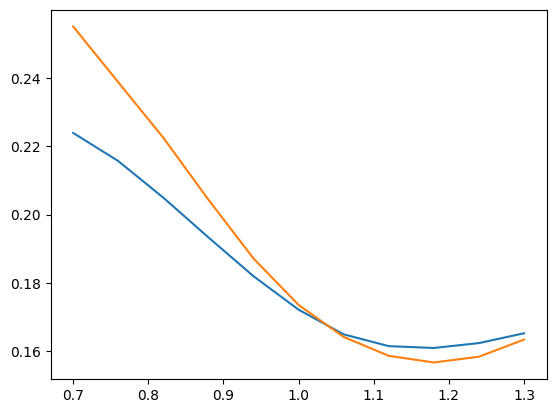

In [15]:
plt.plot(k,iv)
plt.plot(k,ivh)

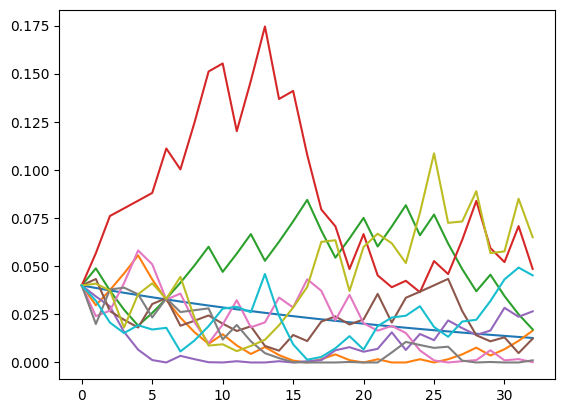

In [27]:
plt.plot(V.detach().numpy()[:,:10])